<a href="https://colab.research.google.com/github/Gasca78/Modelo_Predictivo_Supervivencia_Equina/blob/main/Clasificacion_de_Supervivencia_Equina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Portafolio: Modelo Predictivo para Supervivencia Equina

**Oswaldo Gasca**

**Objetivo:** Este proyecto demuestra el ciclo completo de un problema de clasificación binaria, desde la limpieza de un dataset complejo del mundo real hasta la construcción y evaluación de un modelo de red neuronal con PyTorch para predecir la supervivencia de caballos en función de sus datos clínicos.

In [7]:
# ===================================================================
# 1. Carga de Librerías y Definición de Funciones
# ===================================================================

# Importación de librerías esenciales
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ----------------- Funciones Auxiliares -----------------

def registros_object(data):
    """Analiza y muestra un resumen de las columnas de tipo 'object'."""
    for col in data.columns:
        if data[col].dtype == object:
            print(data[col].value_counts())
            print('Cantidad de variables diferentes',len(data[col].unique()),'\n')

def matriz_corr(data, ancho, alto):
    """Genera y muestra un mapa de calor de la matriz de correlación."""
    matriz_corr = data.corr()
    plt.figure(figsize=(ancho,alto))
    sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Mapa de calor de Correlación del dataset")
    plt.show()

def dummies(data, columnas):
    """Convierte columnas categóricas a variables dummy."""
    return pd.get_dummies(data, columns=columnas, drop_first=True, dtype=float)

def eliminar_columnas_nan(data, threshold):
    """Elimina columnas que superan un umbral de valores NaN."""
    eliminar = {}
    for column in data.columns:
        perc_nan = (data[column].isnull().sum()/len(data))*100
        if perc_nan > threshold:
            eliminar[column]=perc_nan
    print(f'{"Columnas eliminadas":<25}{"Nan %":<10}')
    for col, per in eliminar.items():
        print(f'{col:<25}{per:<10.2f}')
    print(f'Cantidad de columnas eliminadas: {len(eliminar)}')
    new_data = data.drop(labels=eliminar.keys(), axis=1)
    return new_data

def eliminar_registros_nan(data, threshold):
    """Elimina filas que superan un umbral de valores NaN."""
    eliminar = {}
    for i in range(len(data)):
        perc_nan = (data.iloc[i].isnull().sum()/data.shape[1])*100
        if perc_nan > threshold:
            eliminar[i]=perc_nan
    print(f'{"Registros eliminados":<25}{"Nan %":<10}')
    for reg, per in eliminar.items():
        print(f'{reg:<25}{per:<10.2f}')
    print(f'Cantidad de registros eliminados: {len(eliminar)}')
    new_data = data.drop(labels=eliminar.keys(), axis=0)
    return new_data

def rellenar_nan(data):
    """Rellena los valores NaN restantes con la moda de cada columna."""
    for column in data.columns:
        moda = data[column].mode()[0]
        data[column] = data[column].fillna(moda)
    return data

def campos_requeridos(data, columna, thershold):
    """Selecciona características basadas en un umbral de correlación con la variable objetivo."""
    features = []
    for i, val in enumerate(abs(data.corr().loc[columna])[0:-1]):
        if val > thershold:
            features.append(data.columns[i])
    features.remove(columna)
    return features

def accuracy(model, x, y):
    """Calcula la precisión del modelo de clasificación."""
    with torch.no_grad():
        pred = model(x)
        hot_test = pred.round()
        acc = hot_test.eq(y).sum() / y.shape[0]
        return hot_test, acc

def matriz_de_confusion(cm, d1, d2):
    """Grafica una matriz de confusión para evaluación visual."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[d1, d2],
                yticklabels=[d1, d2])
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión')
    plt.show()

def err_vs_iter(values):
    """Grafica la curva de pérdida durante el entrenamiento."""
    plt.plot(values)
    plt.xlabel('Iteraciones')
    plt.ylabel('Error (Loss)')
    plt.title(f'Curva de Aprendizaje: Error vs. Iteraciones')
    plt.show()

def train_model(model, optimizer, criterion, x_train, y_train, x_test, y_test, max_iteration, divisor):
    """Entrena el modelo de red neuronal."""
    train_losses = []
    model.train() # Poner el modelo en modo de entrenamiento
    for iter in range(max_iteration):
        # Forward pass
        output_train = model(x_train)
        loss_train = criterion(output_train, y_train)
        train_losses.append(loss_train.item())
        # Backward pass
        loss_train.backward()
        # Actualización de pesos
        optimizer.step()
        optimizer.zero_grad()
        if (iter + 1) % divisor == 0:
            print(f"Iteracion {iter+1}/{max_iteration}, Train loss = {loss_train.item():.4f}")
    # Evaluación final con datos de prueba
    with torch.no_grad():
        model.eval() # Poner el modelo en modo de evaluación
        y_hat_test = model(x_test)
        loss_test = criterion(y_hat_test, y_test)
    return train_losses, loss_test.item()

## 2. Carga y Análisis Exploratorio de Datos (EDA)

Se carga el dataset y se realiza una primera inspección para entender su estructura, tipos de datos y, crucialmente, la cantidad de datos faltantes. Se observa que el dataset es relativamente pequeño (299 registros) pero tiene una gran cantidad de columnas y muchos valores nulos, lo que presenta un desafío de preprocesamiento significativo.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# 2. Carga y Análisis Exploratorio Inicial (EDA)
# Carga del dataset
data = pd.read_csv('/content/drive/MyDrive/Proyectos_NN_Portafolio/horse.csv')

# Obtener información principal del dataset
print("----------- Información General del Dataset -----------")
data.info()
print("\n----------- Conteo de Valores Nulos por Columna -----------")
print(data.isnull().sum())

----------- Información General del Dataset -----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  na

Se analizan en detalle las variables categóricas (`object`) y numéricas para comprender la distribución y naturaleza de los datos.

In [10]:
# Identificar los diferentes datos de los campos tipo "object"
print("\n--- Análisis de Variables Categóricas ---")
registros_object(data)

# Valores estadísticos básicos del dataset
print("\n--- Análisis de Variables Numéricas ---")
data.describe()


--- Análisis de Variables Categóricas ---
surgery
yes    180
no     119
Name: count, dtype: int64
Cantidad de variables diferentes 2 

age
adult    275
young     24
Name: count, dtype: int64
Cantidad de variables diferentes 2 

temp_of_extremities
cool      108
normal     78
warm       30
cold       27
Name: count, dtype: int64
Cantidad de variables diferentes 5 

peripheral_pulse
normal       114
reduced      103
absent         8
increased      5
Name: count, dtype: int64
Cantidad de variables diferentes 5 

mucous_membrane
normal_pink      79
pale_pink        57
pale_cyanotic    41
bright_pink      30
bright_red       25
dark_cyanotic    20
Name: count, dtype: int64
Cantidad de variables diferentes 7 

capillary_refill_time
less_3_sec    187
more_3_sec     78
3               2
Name: count, dtype: int64
Cantidad de variables diferentes 4 

pain
mild_pain       67
depressed       59
extreme_pain    42
severe_pain     38
alert           38
Name: count, dtype: int64
Cantidad de variable

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,2.990000e+02,239.000000,275.000000,241.000000,53.000000,270.000000,266.000000,101.000000,299.000000,299.000000,299.000000
mean,1.087733e+06,38.168619,72.000000,30.460581,4.707547,46.307407,24.274436,3.039604,3659.709030,90.528428,7.387960
std,1.532032e+06,0.733744,28.646219,17.666102,1.982311,10.436743,27.364194,1.967947,5408.472421,650.637139,127.749768
min,5.184760e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.300000,0.100000,0.000000,0.000000,0.000000
25%,5.289040e+05,37.800000,48.000000,18.000000,3.000000,38.000000,6.500000,2.000000,2111.500000,0.000000,0.000000
50%,5.303010e+05,38.200000,64.000000,25.000000,5.000000,45.000000,7.500000,2.300000,2322.000000,0.000000,0.000000
75%,5.347360e+05,38.500000,88.000000,36.000000,6.500000,52.000000,56.750000,3.900000,3209.000000,0.000000,0.000000
max,5.305629e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,7111.000000,2209.000000


### 3. Limpieza y Preprocesamiento de Datos

Esta es la fase más crítica del proyecto. La estrategia es la siguiente:
1.  **Transformar la Variable Objetivo:** La columna `outcome` se convierte en una variable binaria, donde `1` representa 'lived' y `0` representa 'died' o 'euthanized'.
2.  **Manejo de Valores Nulos (NaN):** Se aplica una estrategia en dos pasos:
    * Primero, se eliminan las columnas y filas que superan un umbral del 50% de valores faltantes, ya que su imputación podría introducir demasiado ruido.
    * Segundo, los valores nulos restantes se imputan utilizando la **moda** de cada columna. Se elige la moda por ser una técnica robusta tanto para variables numéricas como categóricas.
3.  **Codificación de Variables Categóricas:** Todas las variables categóricas restantes se convierten a un formato numérico utilizando `pd.get_dummies` para que puedan ser utilizadas por el modelo.

In [17]:
# 1. Transformar la variable objetivo 'outcome'
data['outcome'] = data['outcome'].replace({'lived':1, 'died':0, 'euthanized':0}).astype(int)

# 2. Eliminar columnas y registros con más del 50% de valores NaN
print("----------- Eliminando Columnas y Registros con Exceso de Nulos -----------")
data = eliminar_columnas_nan(data, 50.0)
print("-" * 35)
data = eliminar_registros_nan(data, 50.0)

# 3. Rellenar los valores NaN restantes con la moda de cada columna
print("\n----------- Imputando Valores Nulos Restantes con la Moda -----------")
data = rellenar_nan(data)
print("\nVerificación de valores nulos después de la limpieza (deben ser 0):")
print(data.isnull().sum().sum())

# 4. Creación de dummies para las variables categóricas restantes
dummi = []
for column in data.columns:
    if data[column].dtype == 'object':
        dummi.append(column)
data = dummies(data, dummi)

print(f"\nDataset limpio y listo. Dimensiones finales: {data.shape}")

----------- Eliminando Columnas y Registros con Exceso de Nulos -----------
Columnas eliminadas      Nan %     
Cantidad de columnas eliminadas: 0
-----------------------------------
Registros eliminados     Nan %     
Cantidad de registros eliminados: 0

----------- Imputando Valores Nulos Restantes con la Moda -----------

Verificación de valores nulos después de la limpieza (deben ser 0):
0

Dataset limpio y listo. Dimensiones finales: (286, 48)


## 4. Selección de Características

Para construir un modelo más eficiente y evitar el ruido, se seleccionan las características más relevantes. Se utiliza la **correlación** entre cada variable y la variable objetivo (`outcome`). Se establece un umbral de `0.15` (valor absoluto) para seleccionar únicamente las características con una influencia moderada o alta en el resultado.

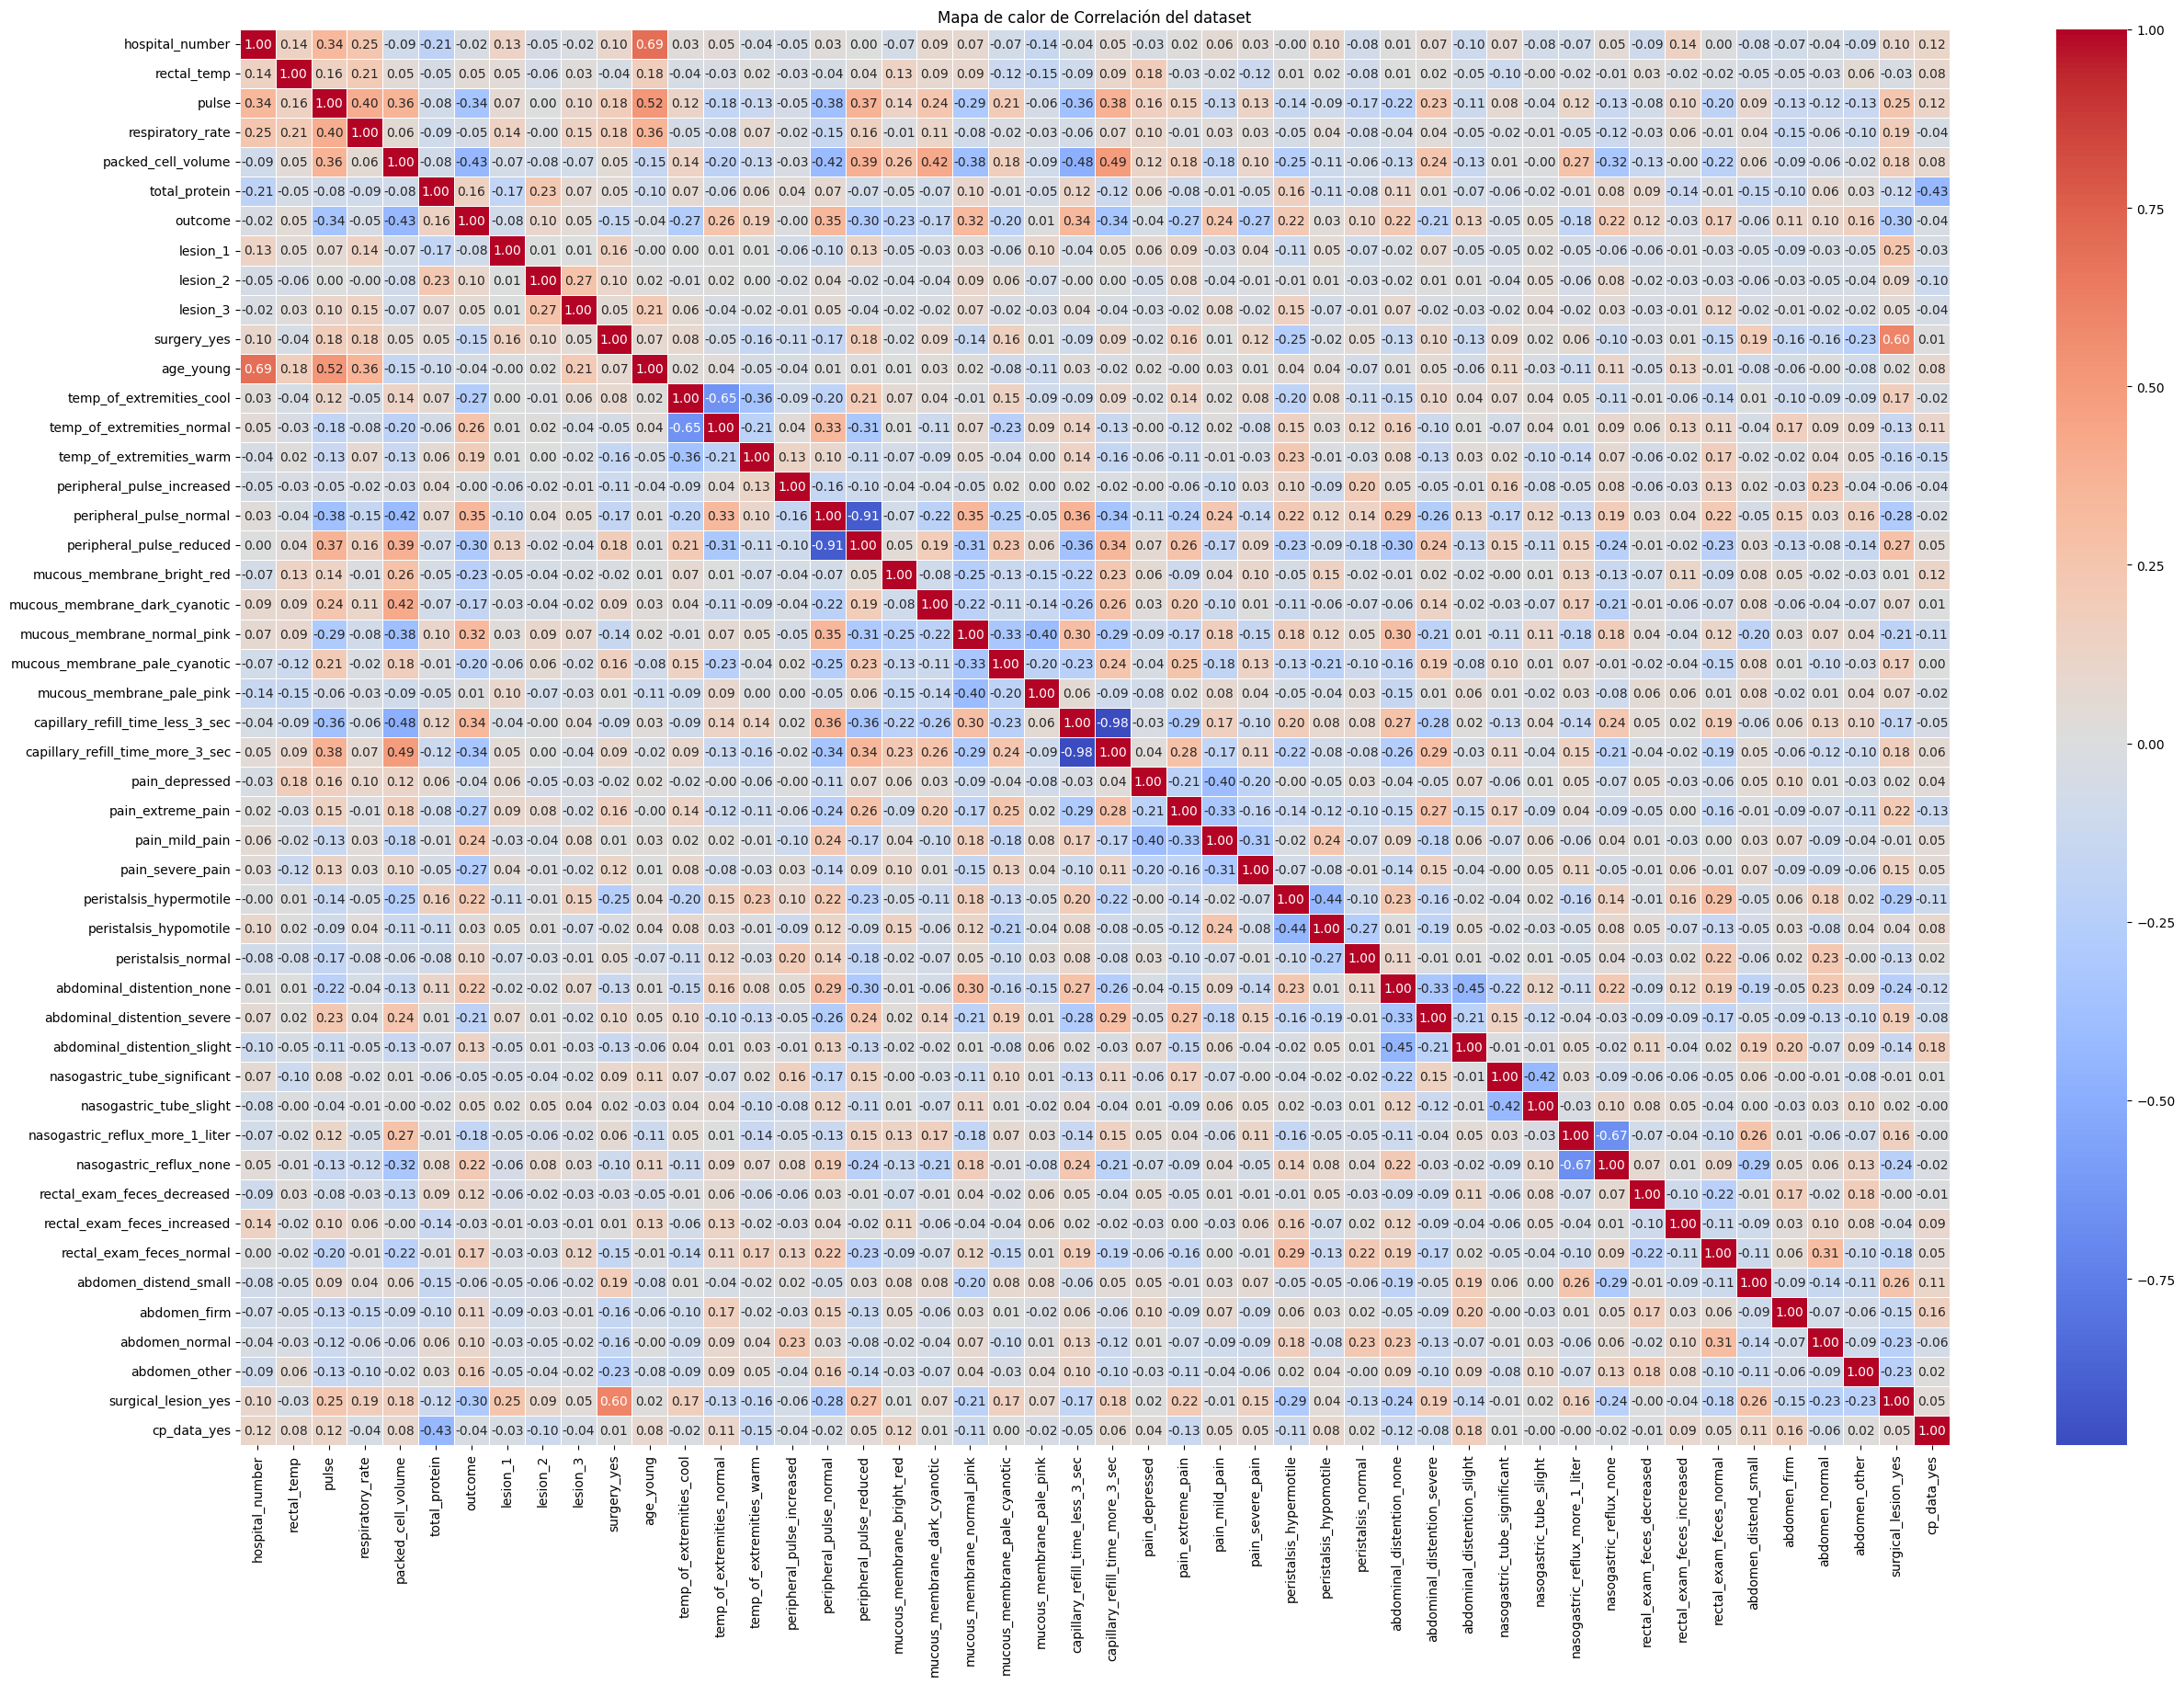

Correlación de cada variable con 'outcome' (en orden descendente):


,outcome
outcome,1.000000
packed_cell_volume,0.425122
peripheral_pulse_normal,0.345608
pulse,0.343200
capillary_refill_time_less_3_sec,0.335891
capillary_refill_time_more_3_sec,0.335278
mucous_membrane_normal_pink,0.321986
surgical_lesion_yes,0.299449
peripheral_pulse_reduced,0.296701
pain_severe_pain,0.270421



Características seleccionadas para el modelo:
['pulse', 'packed_cell_volume', 'total_protein', 'surgery_yes', 'temp_of_extremities_cool', 'temp_of_extremities_normal', 'temp_of_extremities_warm', 'peripheral_pulse_normal', 'peripheral_pulse_reduced', 'mucous_membrane_bright_red', 'mucous_membrane_dark_cyanotic', 'mucous_membrane_normal_pink', 'mucous_membrane_pale_cyanotic', 'capillary_refill_time_less_3_sec', 'capillary_refill_time_more_3_sec', 'pain_extreme_pain', 'pain_mild_pain', 'pain_severe_pain', 'peristalsis_hypermotile', 'abdominal_distention_none', 'abdominal_distention_severe', 'nasogastric_reflux_more_1_liter', 'nasogastric_reflux_none', 'rectal_exam_feces_normal', 'abdomen_other', 'surgical_lesion_yes']


In [12]:
# Visualizar la matriz de correlación completa
matriz_corr(data, 30, 20)

# Ordenar las características por su correlación (absoluta) con 'outcome'
print("Correlación de cada variable con 'outcome' (en orden descendente):")
display(abs(data.corr().loc['outcome']).sort_values(ascending=False))

# Aplicar el umbral para seleccionar las características finales
features = campos_requeridos(data, 'outcome', 0.15)
print("\nCaracterísticas seleccionadas para el modelo:")
print(features)

## 5. Preparación de Datos para el Modelo

Con los datos limpios y las características seleccionadas, se procede a:
1.  **Separar** los datos en variables predictoras (`X`) y la variable objetivo (`Y`).
2.  **Dividir** los datos en conjuntos de entrenamiento (80%) y prueba (20%).
3.  **Escalar** las características utilizando `StandardScaler` para normalizarlas.
4.  **Convertir** los datos de arrays de NumPy a tensores de PyTorch.

In [13]:
# 1. y 2. Separación del dataset en train/test
X = data[features]
Y = data['outcome']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=27)

# 3. Escalamiento de características
s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

# 4. Conversión a tensores de PyTorch
Y_train_np = Y_train.to_numpy()
Y_test_np = Y_test.to_numpy()
X_Train = torch.from_numpy(X_train.astype(np.float32))
X_Test = torch.from_numpy(X_test.astype(np.float32))
Y_Train = torch.from_numpy(Y_train_np.astype(np.float32)).view(-1,1)
Y_Test = torch.from_numpy(Y_test_np.astype(np.float32)).view(-1,1)

print(f"Dimensiones de X_Train: {X_Train.shape}")
print(f"Dimensiones de X_Test: {X_Test.shape}")

Dimensiones de X_Train: torch.Size([228, 26])
Dimensiones de X_Test: torch.Size([58, 26])


## 6. Modelado, Entrenamiento y Evaluación

Se define y entrena una Red Neuronal Densa (DNN).

-   **Arquitectura:** Una capa de entrada, una capa oculta con 5 neuronas (función de activación Tanh) y una capa de salida. La salida final pasa por una función Sigmoide para producir una probabilidad.
-   **Función de Pérdida:** `Binary Cross-Entropy Loss (BCELoss)`, ideal para clasificación binaria.
-   **Optimizador:** `Adam` con una ligera regularización L2 (`weight_decay`) para prevenir el sobreajuste.
-   **Hiperparámetros:** `learning_rate = 1e-4`, `max_iter = 13000`.

In [14]:
# Definición de la arquitectura del modelo
class DNN_b(nn.Module):
    def __init__(self, n, actfun='relu'):
        super(DNN_b, self).__init__()
        self.L = len(n) - 1
        if actfun.lower() == 'sigmoid':
            self.actfun = nn.Sigmoid
        elif actfun.lower() == 'tanh':
            self.actfun = nn.Tanh
        else:
            self.actfun = nn.ReLU
        layers = list()
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))
            layers.append((f'actfun_{i+1}', self.actfun()))
        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

In [15]:
# --- Configuración y Entrenamiento ---

# Definimos las dimensiones de entrada y salida
n_samples, n_features = X_train.shape
input_size = n_features
output_size = 1

# Instanciamos el modelo
model = DNN_b(n = [input_size, 5, output_size], actfun='tanh')

# Verificamos el rendimiento del modelo ANTES del entrenamiento
print("----------- Rendimiento Pre-Entrenamiento -----------")
hot_test, acc_test = accuracy(model, X_Test, Y_Test)
print(f'Accuracy inicial de test: {100*acc_test:.2f}%')

# Hiperparámetros
learning_rate = 1e-4
max_iter = 13000
divisor = 2000

# Optimizador y Función de Pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.BCELoss()

# Proceso de optimización
print("\n----------- Inicio del Entrenamiento -----------")
loss_train, loss_test = train_model(model, optimizer, criterion, X_Train, Y_Train, X_Test, Y_Test, max_iter, divisor)

----------- Rendimiento Pre-Entrenamiento -----------
Accuracy inicial de test: 60.34%

----------- Inicio del Entrenamiento -----------
Iteracion 2000/13000, Train loss = 0.4445
Iteracion 4000/13000, Train loss = 0.3648
Iteracion 6000/13000, Train loss = 0.2998
Iteracion 8000/13000, Train loss = 0.2462
Iteracion 10000/13000, Train loss = 0.2025
Iteracion 12000/13000, Train loss = 0.1696


## 7. Resultados y Conclusión

Tras el entrenamiento, se evalúa el rendimiento final del modelo. La curva de aprendizaje muestra una clara disminución del error, indicando que el modelo aprendió correctamente de los datos.

-   El modelo alcanza una precisión (accuracy) del **94.74%** en el conjunto de entrenamiento.
-   En el conjunto de prueba, logra una precisión del **75.86%**, una mejora significativa sobre el estado inicial y una buena capacidad de generalización.

La matriz de confusión final detalla el rendimiento, mostrando cuántos caballos fueron clasificados correcta e incorrectamente.


----------- Curva de Aprendizaje -----------


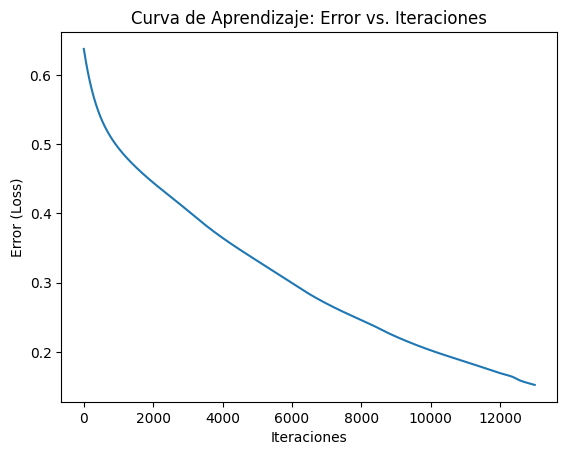


----------- Rendimiento Post-Entrenamiento -----------
Accuracy final de train: 94.74%
Accuracy final de test: 75.86%

----------- Matriz de Confusión Final (Test Set) -----------


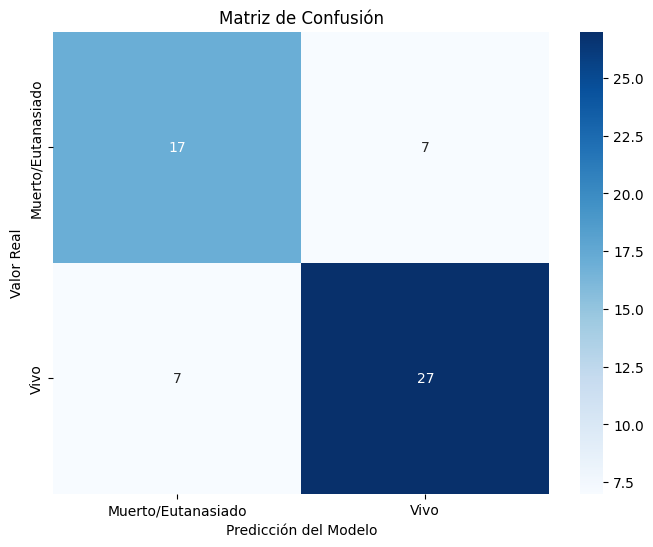

In [16]:
print("\n----------- Curva de Aprendizaje -----------")
err_vs_iter(loss_train)

# Verificamos el rendimiento final del modelo optimizado
print("\n----------- Rendimiento Post-Entrenamiento -----------")
hot_train, acc_train = accuracy(model, X_Train, Y_Train)
print(f'Accuracy final de train: {100*acc_train:.2f}%')
hot_test, acc_test = accuracy(model, X_Test, Y_Test)
print(f'Accuracy final de test: {100*acc_test:.2f}%')

# Evaluación final con la matriz de confusión
print("\n----------- Matriz de Confusión Final (Test Set) -----------")
cm_test = confusion_matrix(Y_Test.numpy(), hot_test.numpy())
matriz_de_confusion(cm_test, 'Muerto/Eutanasiado', 'Vivo')